In [1]:
from triage.component.audition import Auditioner
from triage.component.audition.pre_audition import PreAudition
from triage.component.audition.rules_maker import SimpleRuleMaker, RandomGroupRuleMaker, create_selection_grid

from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import yaml
import sqlalchemy

import logging
logging.basicConfig(level=logging.WARNING)

import pandas as pd
pd.set_option('display.precision', 4)

In [7]:
with open('db_default_profile.yaml') as fd:
    config = yaml.load(fd)
    dburl = sqlalchemy.engine.url.URL(
        "postgres",
        host=config["host"],
        username=config["user"],
        database=config["db"],
        password=config["pass"],
        port=config["port"],
    )
    conn = sqlalchemy.create_engine(dburl, poolclass=sqlalchemy.pool.QueuePool)

# Setting up the Auditioner instance

When using audition, we'll need a few parameters:
- A name for the "best distance" database table that will store the results of the auditioning process.
- The metric and parameter for our evaluations, such as precision@1000_abs

Additionally, you need to specify the set of `model_group_ids` and `train_end_times` you want to use manually, but `PreAudition` provides some tools for grabbing these from the database in some typical use cases.

In [5]:
best_dist_table = 'aud_best_dist' # if you're looking at multiple experiments side-by-side, change this for each one
metric = 'precision@'
parameter = '1000_abs'

## Pre-Audition

`PreAudition` provides some higher level functions to obtain `model_group_ids` and `train_end_times`. For example, `get_model_groups_from_experiment()` and `get_train_end_times()` (note that this will return the `train_end_times` associated with the set of model groups returned by one of the `get_model_groups` methods, so those should be run first)

Note that the `baseline_model_types` parameter in the constructor is optional and can be used to identify model groups as baselines rather than candidates for model selection

In [6]:
pre_aud = PreAudition(
    conn, 
    baseline_model_types=['sklearn.dummy.DummyClassifier'] # optional, requires a list
)

# select model groups by experiment hash id
model_groups = pre_aud.get_model_groups_from_experiment('a1316f404aecc9df9e3c5264b32770f8')

# Alternatively, you can select model groups by label definition using:
# model_groups = pre_aud.get_model_groups_from_label('final_ruling_code_1_4_5_states_klaus_fix_nulls_more_trees')

# Note that this will find train_end_times associated with the model groups defined above
# The "after" parameter is optional
end_times = pre_aud.get_train_end_times(after='2011-01-01')

`get_model_groups_from_experiment()` returns a dictionary with keys `model_groups` and `baseline_model_groups`. How many of each did we get?

In [7]:
# Number of non-baseline model groups:
print(len(model_groups['model_groups']))

72


In [8]:
# Number of baseline model groups:
print(len(model_groups['baseline_model_groups']))

1


`get_train_end_times()` returns a list of `train_end_times`:

In [9]:
end_times

[Timestamp('2011-01-01 00:00:00'),
 Timestamp('2012-01-01 00:00:00'),
 Timestamp('2013-01-01 00:00:00'),
 Timestamp('2014-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2016-01-01 00:00:00')]

Alternatively, you can write your own query to get the sets of `model_group_ids`, `baseline_model_group_ids`, and `train_end_times`.

For instance, for model groups:
```python
sel = """
SELECT DISTINCT(model_group_id)
FROM results.model_groups
WHERE model_config->>'label_definition'='final_ruling_code_1_4_5_states_klaus_fix_nulls_more_trees'
    AND model_type NOT IN ('sklearn.dummy.DummyClassifier')
"""
model_groups = pre_aud.get_model_groups(sel)
```

And for baseline model groups:
```python
sel = """
SELECT DISTINCT(model_group_id)
FROM results.model_groups
WHERE model_config->>'label_definition'='final_ruling_code_1_4_5_states_klaus_fix_nulls_more_trees'
    AND model_type IN ('sklearn.dummy.DummyClassifier')
"""
baseline_model_groups = pre_aud.get_model_groups(sel)
```

And for train_end_times:
```python
sel = """
SELECT DISTINCT train_end_time
FROM results.models
WHERE model_group_id IN ({})
    AND EXTRACT(DAY FROM train_end_time) IN (1)
    AND train_end_time >= '2010-01-01'
;
""".format(', '.join(map(str, model_groups+baseline_model_groups)))

end_times = pre_aud.get_train_end_times(query=sel)
```

## Auditioner

Auditioner is the main API to do the rules selection and model groups selection. It filters model groups using a two-step process.
 - Broad thresholds to filter out truly bad models
 - A selection rule grid to find the best model groups over time for each of a variety of methods
 
Note that model groups that don't have full train_end_time periods will be excluded from the analysis, so it's important to **ensure that all model groups have been completed across all train/test splits**

When we set up our auditioner object, we need to give it a database connection, the model groups to consider (and optionally baseline model groups), train_end_times, and tell it how we're going to filter the models. Note that the `initial_metric_filters` parameter specified below tells `Auditioner` what metric and parameter we'll be using and starts off without any initial filtering constraints (which is what you'll typically want):

In [10]:
aud = Auditioner(
    db_engine = conn,
    model_group_ids = model_groups['model_groups'],
    train_end_times = end_times,
    initial_metric_filters = [{'metric': metric, 'parameter': parameter, 'max_from_best': 1.0, 'threshold_value': 0.0}],
    distance_table = best_dist_table,
    baseline_model_group_ids = model_groups['baseline_model_groups'] # optional
)

# How to use Auditioner

## Plotting the best distance metric and groups over time

This is done with the `plot_model_groups` method and may take a minute to generate. 
What it does is to get rid of really bad model groups wrt the metric of interest. 
    A model group is discarded if:
        - It’s never close to the “best” model (define close to best) or
        - If it’s metric is below a certain number (define min threshold) at least once

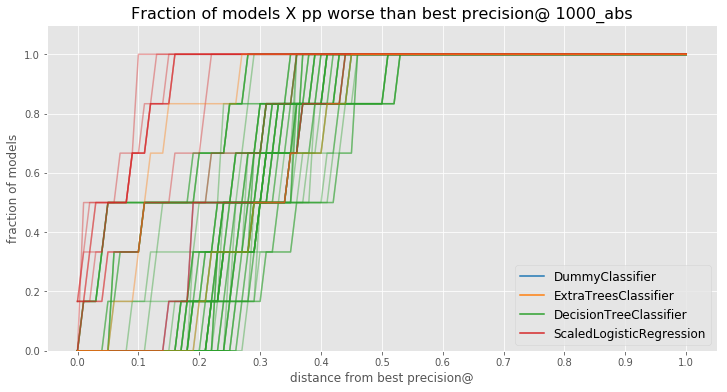

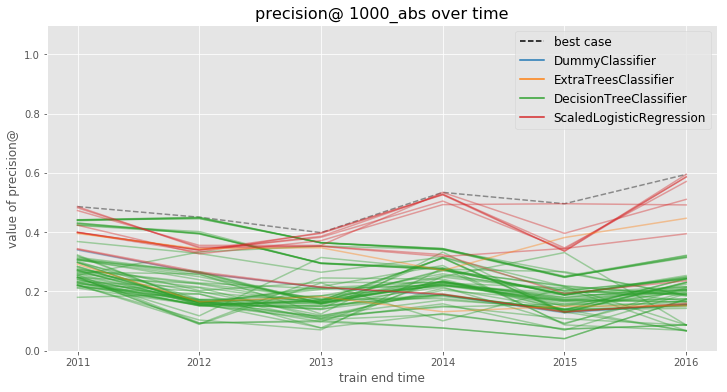

In [11]:
aud.plot_model_groups()

With our first default setting, we don't filter out models because `max_from_best`=`1.0` and `threshold_value`=`0.0` are the loosest criteria.

- The frist graph shows us the fraction of models worse than the best model by distance wrt the metric of interest.
- The second graph shows us the performance of a model group over time. The dashed line is the best case at that time period.

In [12]:
ids = aud.thresholded_model_group_ids

In [13]:
len(ids)

72

## Applying thresholds to weed out bad models

Here we use the `set_one_metric_filter` to apply a simple filter in order to eliminate poorly performing ones. The model groups will be plotted again after updating the filters.

Here's how these filters work:
- In order to meet the `max_from_best` filter, a model group must have *at least one result* under that threshold
- In order to meet the `threshold_value` filter, a model group must have *all results* perform above that threshold

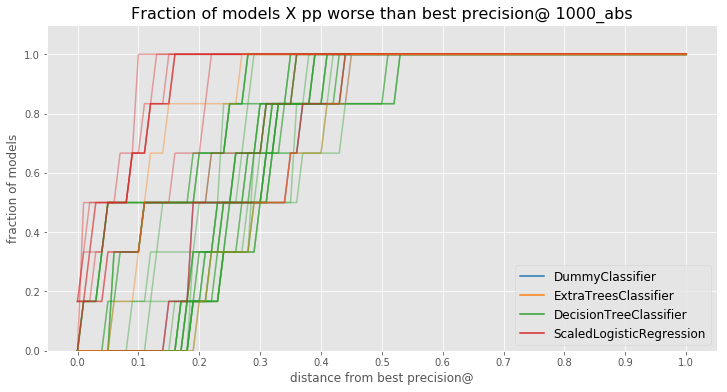

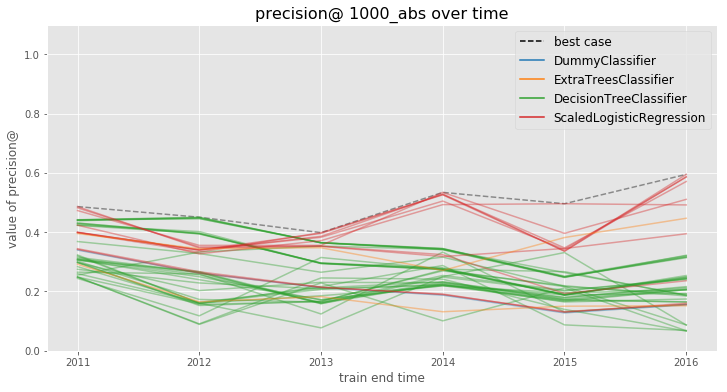

In [14]:
aud.set_one_metric_filter(
    metric=metric, 
    parameter=parameter, 
    max_from_best=0.2, 
    threshold_value=0.0)

Apply a round of filtering, starting with no `threshold_value` and a fairly wide margin on `max_from_best`

In [15]:
# how many model groups are left after the first round of filtering?
len(aud.thresholded_model_group_ids)

44

That didn't thin things out too much, so let's get a bit more agressive with both parameters.
If we want to have multiple filters, then use `update_metric_filters` to apply a set of filters to the model groups we're considering in order to eliminate poorly performing ones. The model groups will be plotted again after updating the filters.

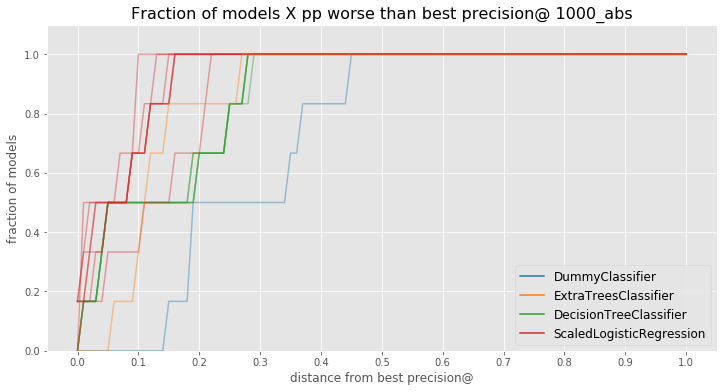

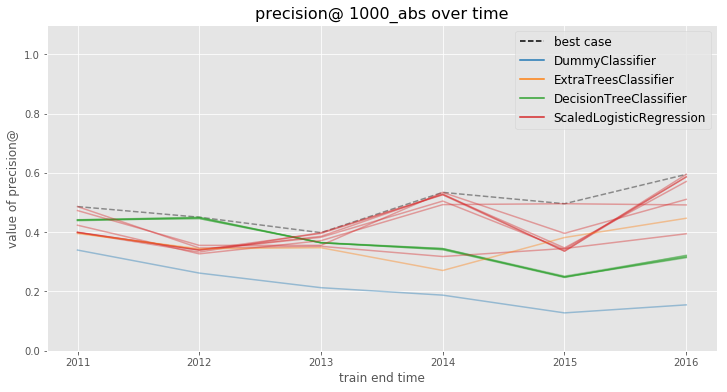

In [19]:
# let's try some more agressive filtering:
aud.update_metric_filters([{
    'metric': metric, 
    'parameter': parameter, 
    'max_from_best': 0.17, 
    'threshold_value': 0.2
}])

That certainly thinned out our candidate models a lot more! In practice, you may need to iterate a few times to find a good set of filter parameters for your specific project.

Note that the `DummyClassifier` model group doesn't meet our filters, but we'll still see it on the audition graphs because we've identified it as a baseline model group (however it won't be included as a candidate for our model selection results)

In [20]:
# how many model groups are left after the latest round of filtering?
len(aud.thresholded_model_group_ids)

13

Note that `aud` is storing the state of the most recent filtering performed, so `aud.thresholded_model_group_ids` will always give you the set of model groups that meet the current filtering parameters. These filters will also apply as a starting point for the selection rules below:

# Applying selection rules and calculating regrets for the narrowed set of models

The goal of audition is to narrow a very large number of model groups to a small number of best candidates, ideally making use of the full time series of information. There are several ways one could consider doing so, using over-time averages of the metrics of interest, weighted averages to balance between metrics, the distance from best metrics, and balancing metric average values and stability.

Audition formalizes this idea through "selection rules" that take in the data up to a given point in time, apply some rule to choose a model group, and evaluate the performance of that chosen model in the subsequent time window, the regret. You can register, evaluate, and update selection rules associated with the Auditioner object as shown below.

Audition will run similations of different model group selection rules to show users and let users asses which rule(s) is the best for their needs. Next, Audition will output numbers of best model in current time period for each model.

## Rules Maker

We need to create a selection rule grid which will be passed to `aud.register_selection_rule_grid()` to run the simulations. The selection rule grid is only recognized as a list of dictionaries of all the parameters. One can create this giant grid by hands, but Audition also provides some helper functions to create the grid easily. 

Note that in these selection rule definitions the parameter `n` specifies how many of the best-performing models (according to that selection strategy) to return when we ask for the current best model groups.

In [28]:
Rule1 = SimpleRuleMaker()

# if we only care about performance on the most recent test set
Rule1.add_rule_best_current_value(metric=metric, parameter=parameter, n=3)

# if we care about the average performance across all test sets
Rule1.add_rule_best_average_value(metric=metric, parameter=parameter, n=3)

# If we care about performance across all test sets, but think recent performance is more important
Rule1.add_rule_best_avg_recency_weight(metric=metric, parameter=parameter, 
                                       curr_weight=[1.5, 2.0, 5.0], decay_type=["linear"], n=3)

# If we only care about stability (regardless of performance)
Rule1.add_rule_lowest_metric_variance(metric=metric, parameter=parameter, n=3)

# If we care about how frequently the model is within a given distance from the best-performing one
Rule1.add_rule_most_frequent_best_dist(metric=metric, parameter=parameter, dist_from_best_case=[0.05], n=3)

# As a comparison point, we could also just choose a model group at random
Rule2 = RandomGroupRuleMaker(n=1)

seln_rules = create_selection_grid(Rule1, Rule2)
seln_rules

[{'shared_parameters': [{'metric': 'precision@', 'parameter': '1000_abs'}],
  'selection_rules': [{'name': 'best_current_value', 'n': 3},
   {'name': 'best_average_value', 'n': 3},
   {'name': 'best_avg_recency_weight',
    'curr_weight': [1.5, 2.0, 5.0],
    'decay_type': ['linear'],
    'n': 3},
   {'name': 'lowest_metric_variance', 'n': 3},
   {'name': 'most_frequent_best_dist',
    'dist_from_best_case': [0.05],
    'n': 3}]},
 {'shared_parameters': [{}],
  'selection_rules': [{'name': 'random_model_group', 'n': 1}]}]

Alternatively, we can create specify our selection rule grid from scratch directly, such as:
```python
seln_rules = [{
        'shared_parameters': [
            {'metric': 'precision@', 'parameter': '200_abs'},
        ],
        'selection_rules': [
            {'name': 'best_current_value', 'n': 3},
            {'name': 'best_average_value', 'n': 3},
            {'name': 'most_frequent_best_dist', 'dist_from_best_case': [0.01, 0.05, 0.1, 0.15], 'n': 3}
        ]
    },
    {
        'shared_parameters': [
            {'metric': 'precision@', 'parameter': '200_abs'}
        ],
        'selection_rules': [
            {'name': 'best_avg_recency_weight', 'curr_weight': [1.5, 2.0, 5.0], 'decay_type': ['linear']}
        ]
    },
    {
        'shared_parameters': [{}],
        'selection_rules': [{'name': 'random_model_group'}]
    }]
```

## Register rules and run the simulations

Register the rules to Audition and it will run the simulations of `regret` and `metric_next_time` for every time period with all the rules and parameters combinations.

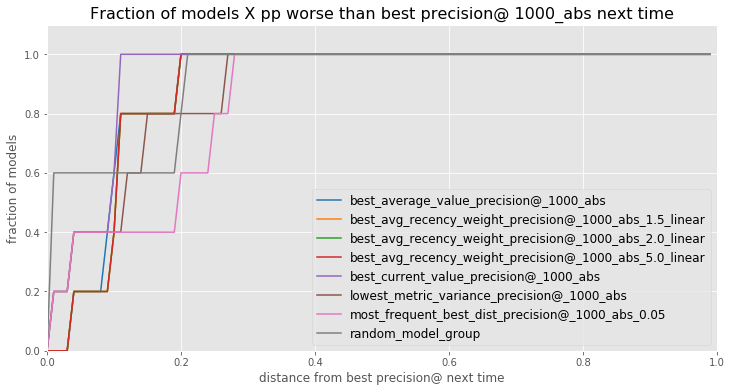

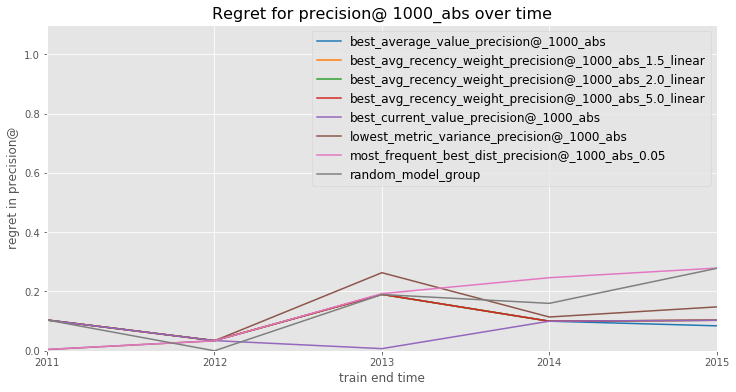

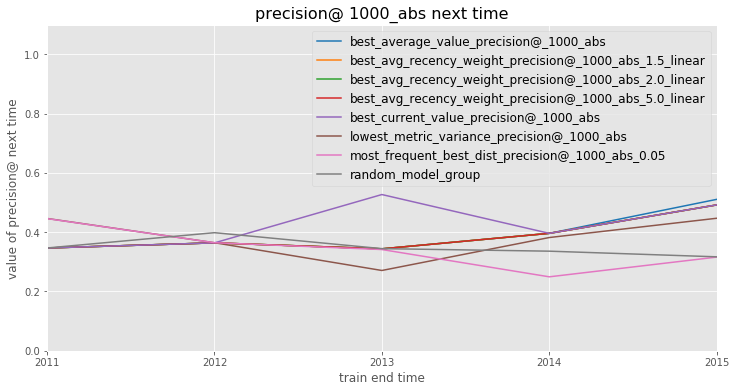

In [29]:
aud.register_selection_rule_grid(seln_rules, plot=True)

We can pull the `results_for_rule` out which is a DataFrame of simulation data. 

In [30]:
aud.results_for_rule[metric+parameter].head()

,model_group_id,raw_value_next_time,regret,selection_rule,train_end_time
0,249,0.3467,0.1039,best_current_value_precision@_1000_abs,2011-01-01
1,214,0.3640,0.0343,best_current_value_precision@_1000_abs,2012-01-01
2,253,0.5270,0.0073,best_current_value_precision@_1000_abs,2013-01-01
3,250,0.3961,0.0999,best_current_value_precision@_1000_abs,2014-01-01
4,251,0.4920,0.1030,best_current_value_precision@_1000_abs,2015-01-01


Finally, when you have a selection rule grid you're happy with, the selection_rule_model_group_ids parameter of the Auditioner will give you the model groups chosen by the selection rules in the grid when applied to the most recent end time for use in application:

In [31]:
aud.selection_rule_model_group_ids

{'best_current_value_precision@_1000_abs': [254, 255, 252],
 'best_average_value_precision@_1000_abs': [250, 251, 254],
 'best_avg_recency_weight_precision@_1000_abs_1.5_linear': [250, 251, 254],
 'best_avg_recency_weight_precision@_1000_abs_2.0_linear': [251, 254, 250],
 'best_avg_recency_weight_precision@_1000_abs_5.0_linear': [254, 251, 255],
 'lowest_metric_variance_precision@_1000_abs': [256, 249, 251],
 'most_frequent_best_dist_precision@_1000_abs_0.05': [188, 189, 196],
 'random_model_group': [196]}